# KampVoter

## Import Library

### Basic Libary

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

from kamp.preprocess import KampDataLoader
from kamp.models import KampVoter

from sklearn.model_selection import RandomizedSearchCV

### Models

In [ ]:
# Boosting Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

## Data Load

In [ ]:
DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'


data_loader = KampDataLoader(
    path = DATA_PATH,

    do_count_trend=False,
    drop_count=False,

    get_useful_p_data=True,
    p_threshold=0.05,

    outlier_method='lof',

    do_resample=False,

    scale_include_cat=False
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[Process Log] Loading Raw Data...
[Process Log] Done

[Process Log] Processing Nan Value...
[Process Log] Done

[Process Log] Encoding Categorical Features...
[Process Log] Done

[Process Log] Removing Outliers (LOF)...
[Process Log] Done

[Process Log] T-Testing...
[Process Log] Done

[Process Log] Data Scaling (MinMaxScaler)...
[Process Log] Done

[Process Log] Train Test Spliting...
[Process Log] Done

======================= [Done] =======================


In [4]:
x_train.to_csv('./data/x_train.csv', index=False)
x_test.to_csv('./data/x_test.csv', index=False)
y_train.to_csv('./data/y_train.csv', index=False)
y_test.to_csv('./data/y_test.csv', index=False)

In [5]:
x_train = pd.read_csv('./data/x_train.csv')
x_test = pd.read_csv('./data/x_test.csv')
y_trian = pd.read_csv('./data/y_train.csv')
y_test = pd.read_csv('./data/y_test.csv')

## Modeling

### Best Version

[Best Version]

```python
# CatBoostClassifier
cat_param_grid = {
    'iterations' : [1000, 1500],
    'learning_rate' : [0.03, 0.05, 0.1],
    'depth' : [6, 8],
    'l2_leaf_reg' : [1, 3, 5],
    'random_state' : [42],
    'verbose' : [0]
}

random_search = RandomizedSearchCV(
    estimator = CatBoostClassifier(),
    param_distributions=cat_param_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

print(f"Best HyperParameters : {random_search.best_params_}")

best_catboost = random_search.best_estimator_


# LGBMClassifier
lgbm_param_grid = {
    'boosting_type' : ['gbdt', 'dart'],
    'n_estimators' : [100, 150, 200, 250, 300, 350, 400],
    'learning_rate' : [0.01, 0.1, 0.5],
    'max_depth' : [-1],
    'random_state' : [42],
    'verbose' : [0]
}

random_search = RandomizedSearchCV(
    estimator = LGBMClassifier(),
    param_distributions=lgbm_param_grid,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

print(f"Best HyperParameters : {random_search.best_params_}")

best_lgbm = random_search.best_estimator_


# XGBClassifier
xgb_param_grid = {
    'n_estimators' : [100, 150, 200, 250, 300, 350],
    'learning_rate' : [0.05, 0.1, 0.3, 0.5],
    'max_depth' : [10, 12, 14, 16, 18],
    'random_state' : [42],
    'verbosity' : [0]
}

random_search = RandomizedSearchCV(
    estimator = XGBClassifier(),
    param_distributions=xgb_param_grid,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

print(f"Best HyperParameters : {random_search.best_params_}")

best_xgb = random_search.best_estimator_


# VotingClassifier
voting_models = {
    'catboost' : best_catboost,
    'lgbm' : best_lgbm,
    'xgb' : best_xgb,
}

model_weights = [1.0, 2.5, 1.0]

kamp_voter = KampVoter(voting_models=voting_models,
                       model_weights=model_weights, 
                       voting_method='soft')
```

```python
"-----------------------------------------------------------"
f1_score : 0.9652173913043478

confusion matrix : 
[[17000    11]
 [   37   666]]

classification report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17011
         1.0       0.98      0.95      0.97       703

    accuracy                           1.00     17714
   macro avg       0.99      0.97      0.98     17714
weighted avg       1.00      1.00      1.00     17714

### CatBoost

In [6]:
cat_param_grid = {
    'iterations' : [1000, 1500],
    'learning_rate' : [0.03, 0.05, 0.1],
    'depth' : [6, 8],
    'l2_leaf_reg' : [1, 3, 5],
    'random_state' : [42],
    'verbose' : [0]
}

random_search = RandomizedSearchCV(
    estimator = CatBoostClassifier(),
    param_distributions=cat_param_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

print(f"Best HyperParameters : {random_search.best_params_}")

best_catboost = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best HyperParameters : {'verbose': 0, 'random_state': 42, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 8}


### LGBM

In [7]:
lgbm_param_grid = {
    'boosting_type' : ['gbdt', 'dart'],
    'n_estimators' : [100, 150, 200, 250, 300, 350, 400],
    'learning_rate' : [0.01, 0.1, 0.5],
    'max_depth' : [-1],
    'random_state' : [42],
    'verbose' : [0]
}

random_search = RandomizedSearchCV(
    estimator = LGBMClassifier(),
    param_distributions=lgbm_param_grid,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

print(f"Best HyperParameters : {random_search.best_params_}")

best_lgbm = random_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best HyperParameters : {'verbose': 0, 'random_state': 42, 'n_estimators': 400, 'max_depth': -1, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}


### XGBoost

In [8]:
xgb_param_grid = {
    'n_estimators' : [100, 150, 200, 250, 300, 350],
    'learning_rate' : [0.05, 0.1, 0.3, 0.5],
    'max_depth' : [10, 12, 14, 16, 18],
    'random_state' : [42],
    'verbosity' : [0]
}

random_search = RandomizedSearchCV(
    estimator = XGBClassifier(),
    param_distributions=xgb_param_grid,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

print(f"Best HyperParameters : {random_search.best_params_}")

best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best HyperParameters : {'verbosity': 0, 'random_state': 42, 'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.1}


### VotingClassifier

In [9]:
voting_models = {
    'catboost' : best_catboost,
    'lgbm' : best_lgbm,
    'xgb' : best_xgb,
}

model_weights = [1.0, 2.5, 1.0]

kamp_voter = KampVoter(voting_models=voting_models,
                       model_weights=model_weights, 
                       voting_method='soft')

In [10]:
kamp_voter.fit(x_train, y_train)

[Voting] ................. (1 of 3) Processing catboost, total=  12.1s
[Voting] ..................... (2 of 3) Processing lgbm, total=   0.9s
[Voting] ...................... (3 of 3) Processing xgb, total=   1.1s


VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x00000235A9889390>),
                             ('lgbm',
                              LGBMClassifier(n_estimators=400, random_state=42,
                                             verbose=0)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_c...
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=12,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 verbose=1, voting='soft', weights=[1.0, 2.5, 1.0])

## Evaluation

In [11]:
kamp_voter.evaluate(x_train, y_train)

f1_score : 1.0

confusion matrix : 
[[68043     0]
 [    0  2812]]

classification report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     68043
         1.0       1.00      1.00      1.00      2812

    accuracy                           1.00     70855
   macro avg       1.00      1.00      1.00     70855
weighted avg       1.00      1.00      1.00     70855




In [12]:
kamp_voter.evaluate(x_test, y_test)

f1_score : 0.9652173913043478

confusion matrix : 
[[17000    11]
 [   37   666]]

classification report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17011
         1.0       0.98      0.95      0.97       703

    accuracy                           1.00     17714
   macro avg       0.99      0.97      0.98     17714
weighted avg       1.00      1.00      1.00     17714




## Feature Importance

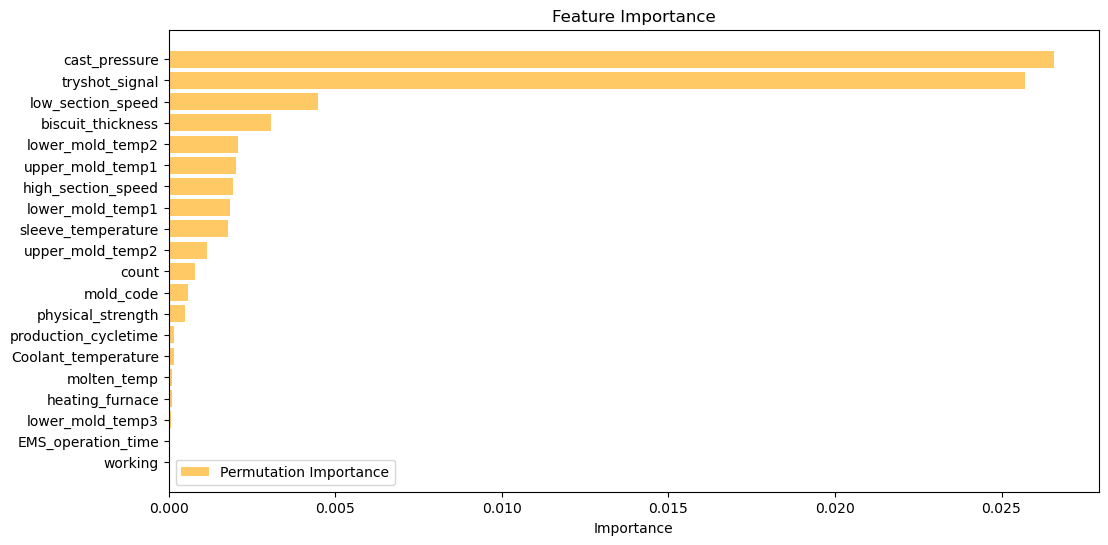

In [14]:
# Permutation Importance 사용
perm_importance = permutation_importance(kamp_voter.voting_classifier, x_test, y_test, n_repeats=30, random_state=42)

sorted_indices_perm = np.argsort(perm_importance.importances_mean)

# 4. 시각화
feature_names = x_test.columns.tolist()
plt.figure(figsize=(12, 6))
# plt.barh(x_test.columns.tolist(), perm_importance.importances_mean, align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.barh(np.array(feature_names)[sorted_indices_perm], perm_importance.importances_mean[sorted_indices_perm], 
         align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()

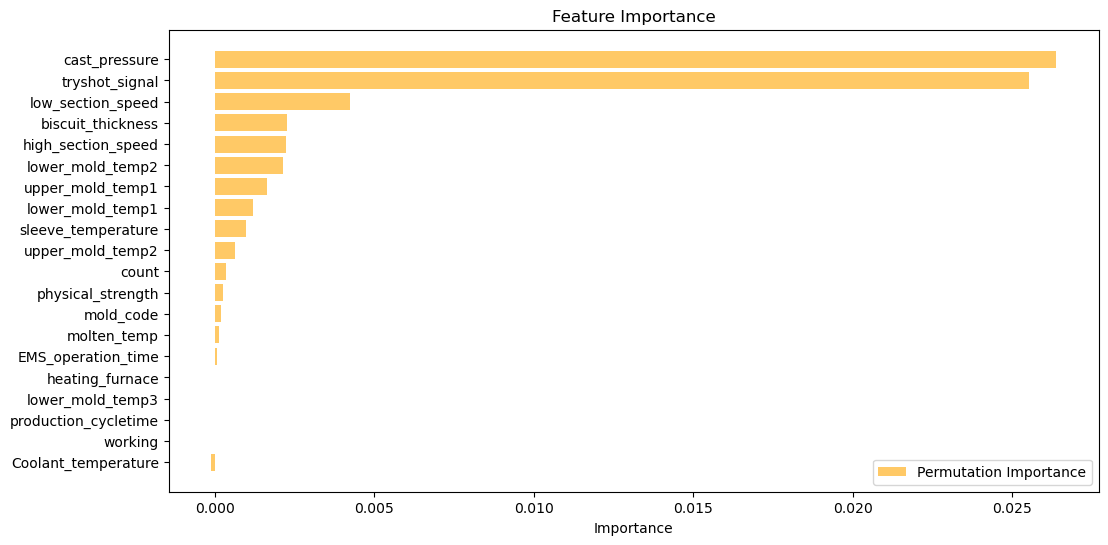

In [15]:
# Permutation Importance 사용
perm_importance = permutation_importance(best_catboost, x_test, y_test, n_repeats=30, random_state=42)

sorted_indices_perm = np.argsort(perm_importance.importances_mean)

# 4. 시각화
feature_names = x_test.columns.tolist()
plt.figure(figsize=(12, 6))
# plt.barh(x_test.columns.tolist(), perm_importance.importances_mean, align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.barh(np.array(feature_names)[sorted_indices_perm], perm_importance.importances_mean[sorted_indices_perm], 
         align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()

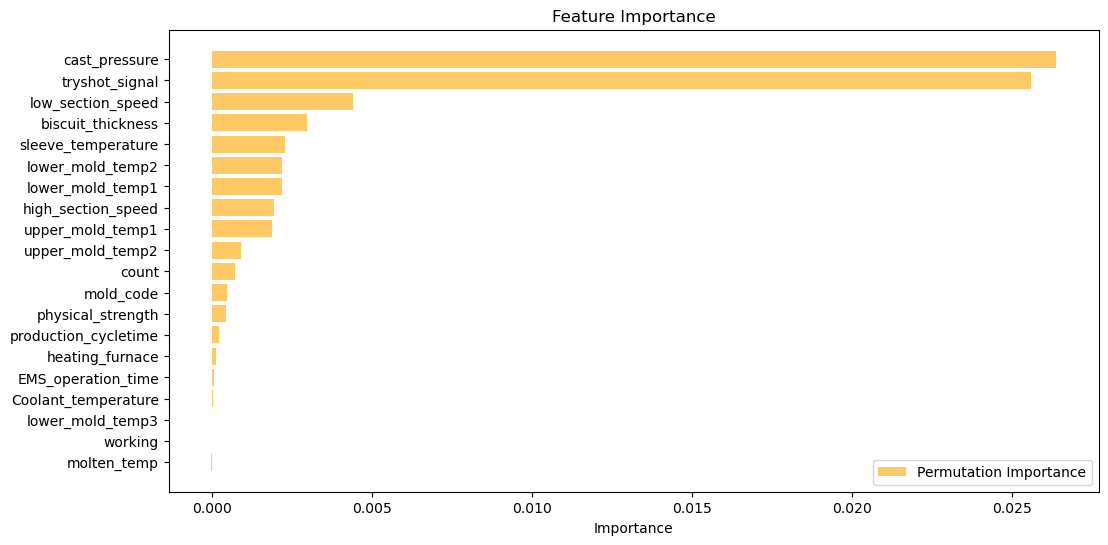

In [16]:
# Permutation Importance 사용
perm_importance = permutation_importance(best_lgbm, x_test, y_test, n_repeats=30, random_state=42)

sorted_indices_perm = np.argsort(perm_importance.importances_mean)

# 4. 시각화
feature_names = x_test.columns.tolist()
plt.figure(figsize=(12, 6))
# plt.barh(x_test.columns.tolist(), perm_importance.importances_mean, align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.barh(np.array(feature_names)[sorted_indices_perm], perm_importance.importances_mean[sorted_indices_perm], 
         align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()

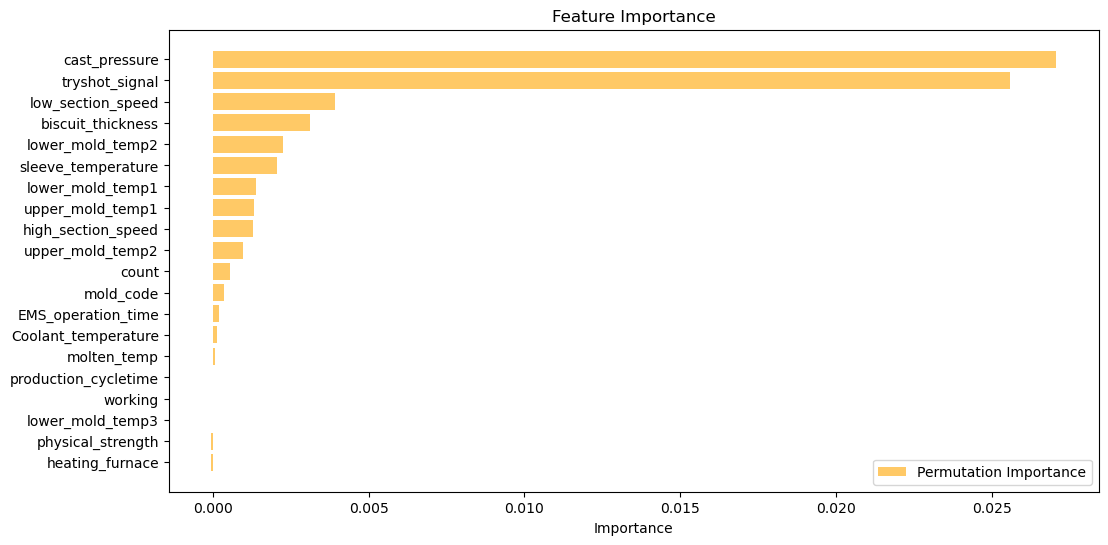

In [17]:
# Permutation Importance 사용
perm_importance = permutation_importance(best_xgb, x_test, y_test, n_repeats=30, random_state=42)

sorted_indices_perm = np.argsort(perm_importance.importances_mean)

# 4. 시각화
feature_names = x_test.columns.tolist()
plt.figure(figsize=(12, 6))
# plt.barh(x_test.columns.tolist(), perm_importance.importances_mean, align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.barh(np.array(feature_names)[sorted_indices_perm], perm_importance.importances_mean[sorted_indices_perm], 
         align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()